In [20]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import model_evaluation_utils as meu

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder

import gensim
import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense

In [4]:
dataset = pd.read_csv("movie_reviews.csv")

print(dataset.head())
reviews = np.array(dataset["review"])
sentiments = np.array(dataset["sentiment"])

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

norm_train_reviews = tn.normalize_corpus(train_reviews)
norm_test_reviews = tn.normalize_corpus(test_reviews)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [10]:
le = LabelEncoder()
num_classes =2
# tokenize train reviews and encode train labels
tokenized_train = [tn.tokenizer.tokenize(text) for text in norm_train_reviews]
y_tr = le.fit_transform(train_sentiments)
y_train = keras.utils.to_categorical(y_tr, num_classes)
# tokenize test reviews and encode test labels
tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_reviews]
y_ts = le.fit_transform(test_sentiments)
y_test = keras.utils.to_categorical(y_ts, num_classes)

# print class label encoding map and encoded label
print("Sentiment class label map:", dict(zip(le.classes_, le.transform(le.classes_))))
print("Sample test label transformation:\n"+"-"*35,
      "\nActual Labels:", test_sentiments[:3], "\nEncoded Labels", y_ts[:3],
      "\nOne hot encoded Labels:\n", y_test[:3]
     )

Sentiment class label map: {'negative': 0, 'positive': 1}
Sample test label transformation:
----------------------------------- 
Actual Labels: ['negative' 'positive' 'negative'] 
Encoded Labels [0 1 0] 
One hot encoded Labels:
 [[1. 0.]
 [0. 1.]
 [1. 0.]]


In [11]:
# build word2vec model
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=150, min_count=10, sample=1e-3)

In [12]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0
        for word in words:
            if word in vocabulary:
                nwords = nwords + 1
                feature_vector = np.add(feature_vector, model[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
        return feature_vector
    
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

In [13]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model, num_features=500)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model, num_features=500)

<ipython-input-12-b815fb369250>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vector = np.add(feature_vector, model[word])


In [14]:
# feature engineering with GloVe model
train_nlp = [tn.nlp(item) for item in norm_train_reviews]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [tn.nlp(item) for item in norm_test_reviews]
test_glove_features = np.array([item.vector for item in test_nlp])

In [16]:
print("Word2Vec model:> Train features shape:", avg_wv_train_features.shape,
      "Test feature shape", avg_wv_test_features.shape
     )
print("GloVe model:> Train features shape:", train_glove_features.shape,
      "Test feature shape", test_glove_features.shape
     )

Word2Vec model:> Train features shape: (35000, 500) Test feature shape (15000, 500)
GloVe model:> Train features shape: (35000, 96) Test feature shape (15000, 96)


In [18]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation="relu", input_shape=(num_input_features,)))
    dnn_model.add(Dropout(.2))
    dnn_model.add(Dense(512, activation="relu"))
    dnn_model.add(Dropout(.2))
    dnn_model.add(Dense(512, activation="relu"))
    dnn_model.add(Dropout(.2))
    dnn_model.add(Dense(2))
    dnn_model.add(Activation("softmax"))
    
    dnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return dnn_model

In [19]:
w2v_dnn = construct_deepnn_architecture(num_input_features=500)

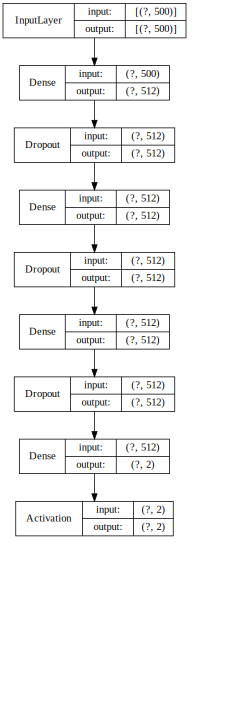

In [21]:
SVG(model_to_dot(w2v_dnn, show_shapes=True, show_layer_names=False, rankdir="TB").create(prog="dot", format="svg"))

In [22]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, y_train, epochs=5, batch_size=batch_size, shuffle=True, validation_split=.1, verbose=1)

Epoch 1/5
315/315 [==============================] - 2s 5ms/step - loss: 0.3096 - accuracy: 0.8705 - val_loss: 0.3034 - val_accuracy: 0.8706
Epoch 2/5
315/315 [==============================] - 1s 5ms/step - loss: 0.2851 - accuracy: 0.8824 - val_loss: 0.2972 - val_accuracy: 0.8780
Epoch 3/5
315/315 [==============================] - 1s 4ms/step - loss: 0.2793 - accuracy: 0.8849 - val_loss: 0.3022 - val_accuracy: 0.8714
Epoch 4/5
315/315 [==============================] - 1s 4ms/step - loss: 0.2705 - accuracy: 0.8874 - val_loss: 0.3046 - val_accuracy: 0.8774
Epoch 5/5
315/315 [==============================] - 1s 4ms/step - loss: 0.2618 - accuracy: 0.8908 - val_loss: 0.3019 - val_accuracy: 0.8689


In [23]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, classes=["positive", "negative"])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Model Performance metrics:
------------------------------
Accuracy: 0.8809
Precision: 0.8823
Recall: 0.8809
F1 Score: 0.8807

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.86      0.91      0.88      7510
    negative       0.91      0.85      0.88      7490

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



In [24]:
# build DNN model
glove_dnn = construct_deepnn_architecture(num_input_features=96)
# train DNN model on GloVe training features
batch_size = 100
glove_dnn.fit(train_glove_features, y_train, epochs=5, batch_size=batch_size, shuffle=True, validation_split=.1, verbose=1)

y_pred = glove_dnn.predict_classes(test_glove_features)
predictions = le.inverse_transform(y_pred)

meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, classes=["positive", "negative"])

Epoch 1/5
315/315 [==============================] - 1s 3ms/step - loss: 0.6481 - accuracy: 0.6255 - val_loss: 0.6292 - val_accuracy: 0.6429
Epoch 2/5
315/315 [==============================] - 1s 3ms/step - loss: 0.6232 - accuracy: 0.6533 - val_loss: 0.6242 - val_accuracy: 0.6606
Epoch 3/5
315/315 [==============================] - 1s 3ms/step - loss: 0.6156 - accuracy: 0.6641 - val_loss: 0.6273 - val_accuracy: 0.6471
Epoch 4/5
315/315 [==============================] - 1s 3ms/step - loss: 0.6132 - accuracy: 0.6662 - val_loss: 0.6212 - val_accuracy: 0.6603
Epoch 5/5
315/315 [==============================] - 1s 3ms/step - loss: 0.6109 - accuracy: 0.6658 - val_loss: 0.6400 - val_accuracy: 0.6317
Model Performance metrics:
------------------------------
Accuracy: 0.6476
Precision: 0.6782
Recall: 0.6476
F1 Score: 0.6316

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.60      0.86      0.71      7510
